## E-Commerce Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# For splitting and basic model analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict, deque

from IPython.display import Image

import pickle

In [2]:
import os

# Define base directory
base_dir = r"C:\Users\sammu\Downloads\Recommendation System Project"  # Change this if needed

# Ensure the directory exists
if not os.path.exists(base_dir):
    print(f"Error: The directory '{base_dir}' does not exist.")
else:
    # Load datasets
    try:
        events_df = pd.read_csv(os.path.join(base_dir, "events.csv"))
        items_part1 = pd.read_csv(os.path.join(base_dir, "item_properties_part1.1.csv"))
        items_part2 = pd.read_csv(os.path.join(base_dir, "item_properties_part2.csv"), header=None)

        # Ensure column names match between both parts
        items_part2.columns = items_part1.columns

        # Merge both parts
        items_df = pd.concat([items_part1, items_part2], ignore_index=True)

        # Save merged file for future use
        items_df.to_csv(os.path.join(base_dir, "item_properties.csv"), index=False)

        # Load categories data
        categories_df = pd.read_csv(os.path.join(base_dir, "category_tree.csv"))

        # Display first few rows
        print("Events Data:")
        display(events_df.head())

        print("Combined Item Properties Data:")
        display(items_df.head())

        print("Category Tree Data:")
        display(categories_df.head())

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Unexpected Error: {e}")


Events Data:


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


Combined Item Properties Data:


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


Category Tree Data:


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [3]:
import os
print(os.listdir(base_dir))

['.ipynb_checkpoints', 'About Recommendation System Dataset.pdf', 'category_tree.csv', 'events.csv', 'item_properties.csv', 'item_properties_part1.1.csv', 'item_properties_part2.csv', 'Product_Recommendation_System.ipynb', 'Recommendation System Project.docx', 'RECOMMENDATION SYSTEM PROJECT.pdf', 'Recommendation-System-Project', '~$commendation System Project.docx']


In [4]:
# Check missing values in all datasets
print("Missing values in events dataset:")
print(events_df.isnull().sum())

print("\nMissing values in items dataset:")
print(items_df.isnull().sum())

print("\nMissing values in categories dataset:")
print(categories_df.isnull().sum())

Missing values in events dataset:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

Missing values in items dataset:
timestamp    0
itemid       0
property     0
value        0
dtype: int64

Missing values in categories dataset:
categoryid     0
parentid      25
dtype: int64


In [5]:
print("Events dataset shape:", events_df.shape)
print("Item properties dataset shape:", items_df.shape)
print("Category tree dataset shape:", categories_df.shape)

print("\nEvents dataset columns:", events_df.columns)
print("\nItem properties dataset columns:", items_df.columns)
print("\nCategory tree dataset columns:", categories_df.columns)

Events dataset shape: (2756101, 5)
Item properties dataset shape: (20275903, 4)
Category tree dataset shape: (1669, 2)

Events dataset columns: Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')

Item properties dataset columns: Index(['timestamp', 'itemid', 'property', 'value'], dtype='object')

Category tree dataset columns: Index(['categoryid', 'parentid'], dtype='object')


## 1️⃣Handling Missing Values
### Events Dataset: Handling transactionid missing values

#### The transactionid column is missing for views and add-to-cart events (which don’t involve transactions).

#### Solution: Fill missing values with "No Transaction"

In [7]:
# Fill missing transactionid values
events_df["transactionid"].fillna("No Transaction", inplace=True)

## 2️⃣ Categories Dataset: Handling parentid missing values
### parentid missing means the category is a top-level category
### Solution: Fill missing parentid values with "Root"

In [9]:
# Fill missing parentid with "Root"
categories_df["parentid"].fillna("Root", inplace=True)

### Converting timestamp to Datetime Format

In [11]:
# Convert timestamp column to numeric format
events_df["timestamp"] = pd.to_numeric(events_df["timestamp"], errors="coerce")
items_df["timestamp"] = pd.to_numeric(items_df["timestamp"], errors="coerce")

# Convert from milliseconds to seconds
events_df["timestamp"] = events_df["timestamp"] // 1000
items_df["timestamp"] = items_df["timestamp"] // 1000

# Define valid timestamp range (2010 - 2030)
valid_min = 1262304000  # 2010-01-01
valid_max = 1924992000  # 2030-12-31

# Filter out invalid timestamps
events_df = events_df[(events_df["timestamp"] >= valid_min) & (events_df["timestamp"] <= valid_max)]
items_df = items_df[(items_df["timestamp"] >= valid_min) & (items_df["timestamp"] <= valid_max)]

# Convert timestamps to datetime format
events_df["timestamp"] = pd.to_datetime(events_df["timestamp"], unit="s")
items_df["timestamp"] = pd.to_datetime(items_df["timestamp"], unit="s")

print("✅ Timestamp conversion successful!")

✅ Timestamp conversion successful!


# Exploratory Data Analysis (EDA)

#### Data Cleaning and Validation

In [14]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12,257597,view,355908,No Transaction
1,2015-06-02 05:50:14,992329,view,248676,No Transaction
2,2015-06-02 05:13:19,111016,view,318965,No Transaction
3,2015-06-02 05:12:35,483717,view,253185,No Transaction
4,2015-06-02 05:02:17,951259,view,367447,No Transaction


In [15]:
events_df.tail()

,timestamp,visitorid,event,itemid,transactionid
2756096,2015-08-01 03:13:05,591435,view,261427,No Transaction
2756097,2015-08-01 03:30:13,762376,view,115946,No Transaction
2756098,2015-08-01 02:57:00,1251746,view,78144,No Transaction
2756099,2015-08-01 03:08:50,1184451,view,283392,No Transaction
2756100,2015-08-01 03:36:03,199536,view,152913,No Transaction


In [16]:
events_df.shape

(2756101, 5)

In [17]:
#Checking for duplicates
events_df.duplicated().sum()

4092

In [18]:
#dropping duplicate values
events_df.drop_duplicates(inplace=True)

In [19]:
#confirming whether duplicate values are dropped
events_df.duplicated().sum()

0

#### There is no duplicated data

In [21]:
#checking for missing values
events_df.isna().sum()

timestamp        0
visitorid        0
event            0
itemid           0
transactionid    0
dtype: int64

##### There are no missing values in timestamp, visitorid, event and itemid except transactionid which has 2733184 missing values. This is because, once an individual just views or adds to cart without making a transaction, he or she will not get a transaction id.

In [23]:
# Handling missing values in the transactionid
# Fill missing transaction IDs with 0 (assuming NaN means no purchase)
events_df["transactionid"] = events_df["transactionid"].fillna(0)

In [24]:
# checking for missing values in event data after handling missing values in the transactionid column.
events_df.isna().sum()

timestamp        0
visitorid        0
event            0
itemid           0
transactionid    0
dtype: int64

In [25]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2752009 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 126.0+ MB


In [26]:
events_df.describe()

,timestamp,visitorid,itemid
count,2752009,2.752009e+06,2.752009e+06
mean,2015-07-09 06:30:06.912239104,7.019248e+05,2.349257e+05
min,2015-05-03 03:00:04,0.000000e+00,3.000000e+00
25%,2015-06-05 04:11:53,3.505660e+05,1.181260e+05
50%,2015-07-09 14:06:54,7.020640e+05,2.360740e+05
75%,2015-08-10 16:26:50,1.053462e+06,3.507190e+05
max,2015-09-18 02:59:47,1.407579e+06,4.668670e+05
std,NaN,4.056914e+05,1.341937e+05


In [27]:
events_df.describe(include='object')

,event,transactionid
count,2752009,2752009
unique,3,17673
top,view,No Transaction
freq,2662136,2729558


In [28]:
events_df['event'].value_counts()

event
view           2662136
addtocart        67422
transaction      22451
Name: count, dtype: int64

In [29]:
events_df['itemid'].value_counts()

itemid
187946    3411
461686    2969
5411      2330
370653    1854
219512    1796
          ... 
337624       1
77963        1
197444       1
297569       1
177353       1
Name: count, Length: 235061, dtype: int64

In [30]:
events_df['event'].count()

2752009

In [31]:
events_df['transactionid'].value_counts()

transactionid
No Transaction    2729558
7063.0                 31
765.0                  28
8351.0                 27
2753.0                 23
                   ...   
14659.0                 1
17064.0                 1
12124.0                 1
10151.0                 1
17579.0                 1
Name: count, Length: 17673, dtype: int64

In [32]:
# Sanity checks for the item_properties
items_df.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


In [33]:
items_df.tail()

,timestamp,itemid,property,value
20275898,2015-06-07 03:00:00,236931,929,n12.000
20275899,2015-08-30 03:00:00,455746,6,150169 639134
20275900,2015-08-16 03:00:00,347565,686,610834
20275901,2015-06-07 03:00:00,287231,867,769062
20275902,2015-09-13 03:00:00,275768,888,888666 n10800.000 746840 1318567


In [34]:
items_df.shape

(20275902, 4)

In [35]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 20275902
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     object        
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 773.5+ MB


In [36]:
items_df.describe()

,timestamp
count,20275902
mean,2015-06-24 14:42:23.682880256
min,2015-05-10 03:00:00
25%,2015-05-24 03:00:00
50%,2015-06-07 03:00:00
75%,2015-07-26 03:00:00
max,2015-09-13 03:00:00


In [37]:
items_df.describe(include='object')

,itemid,property,value
count,20275902,20275902,20275902
unique,527365,1104,1966868
top,158903,888,769062
freq,462,3000398,1537247


In [38]:
#checking duplicated values
items_df.duplicated().sum()

0

In [39]:
#checking for null values
items_df.isna().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

In [40]:
# Basic info
print("=== EVENTS DATASET EXPLORATION ===\n")
print("1. Basic Info")
events_df.info()

# Null values
print("\n2. Null Values per Column:")
print(events_df.isnull().sum())

# Percentage of null values
print("\n3. Percentage of Null Values per Column:")
print((events_df.isnull().sum() / events_df.shape[0]) * 100)

# Unique values in each column
print("\n4. Unique Value Counts per Column:")
for col_name in events_df.columns:
    unique_vals = events_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")

=== EVENTS DATASET EXPLORATION ===

1. Basic Info
<class 'pandas.core.frame.DataFrame'>
Index: 2752009 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 126.0+ MB

2. Null Values per Column:
timestamp        0
visitorid        0
event            0
itemid           0
transactionid    0
dtype: int64

3. Percentage of Null Values per Column:
timestamp        0.0
visitorid        0.0
event            0.0
itemid           0.0
transactionid    0.0
dtype: float64

4. Unique Value Counts per Column:
  timestamp: 2357232
  visitorid: 1407580
  event: 3
  itemid: 235061
  transactionid: 17673


### Distribution of Event Types

=== Distribution of Event Types ===
event
view           2662136
addtocart        67422
transaction      22451
Name: count, dtype: int64


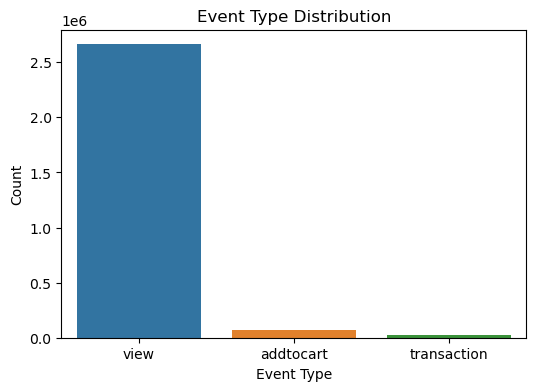

In [42]:
# Distribution of 'event' column
print("=== Distribution of Event Types ===")
event_counts = events_df['event'].value_counts()
print(event_counts)

# Visualize with a countplot
plt.figure(figsize=(6,4))
sns.countplot(x='event', data=events_df, order=event_counts.index)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

### User-Level Analysis

In [44]:
# Group by visitorid to see how many events each user performed
user_event_counts = events_df.groupby('visitorid')['event'].count()
print("=== User-Level Analysis ===")
print("Distribution of events per user:")
print(user_event_counts.describe())

user_event_counts.value_counts()

=== User-Level Analysis ===
Distribution of events per user:
count    1.407580e+06
mean     1.955135e+00
std      1.257115e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      7.755000e+03
Name: event, dtype: float64


event
1       1002326
2        205738
3         79461
4         38732
5         22889
         ...   
1610          1
726           1
463           1
4328          1
469           1
Name: count, Length: 351, dtype: int64

### Item-Level Analysis

In [46]:
# Group by itemid to see how many events each item has
item_event_counts = events_df.groupby('itemid')['event'].count()
print("=== Item-Level Analysis ===")
print("Distribution of events per item:")
print(item_event_counts.describe())

item_event_counts.value_counts()

=== Item-Level Analysis ===
Distribution of events per item:
count    235061.000000
mean         11.707638
std          36.968681
min           1.000000
25%           1.000000
50%           3.000000
75%           9.000000
max        3411.000000
Name: event, dtype: float64


event
1      73687
2      34812
3      21074
4      14612
5      10642
       ...  
487        1
958        1
645        1
609        1
307        1
Name: count, Length: 597, dtype: int64

### Initial inferences for the Events dataset

##### 1. Basic Info, Null Values, Unique Values

Shape & Memory Usage

2,756,101 total rows and 5 columns (timestamp, visitorid, event, itemid, transactionid).
Memory usage is about 105 MB.
Null Values

transactionid has ~2.73 million nulls, i.e., 99.185% of the dataset.
This is expected since transactionid only applies to event == 'transaction', which is relatively rare.

####  Unique Values
1. timestamp: ~2.75 million unique values (nearly one per row).
2. visitorid: ~1.41 million unique users.
3. event: 3 distinct types (view, addtocart, transaction).
4. itemid: ~235k unique items.
5. transactionid: ~17.7k unique transaction IDs (applicable only to 'transaction' events).

The high null rate for transactionid confirms that most events are non-transaction (either 'view' or 'addtocart').

Large numbers of unique visitors and items indicate a long-tail scenario data.

Memory usage is significant but still within a manageable range for standard data analysis.

#### 2. Distribution of Event Types

1. A bar chart confirms 'view' events dominate, 'addtocart' is smaller, and 'transaction' is the smallest.
2. The data forms a conversion funnel: many views, fewer add-to-carts, and even fewer transactions.
3. The ratio suggests only a small fraction of users eventually add items to cart or make a  purchase. 

#### 3. User-Level Analysis

1. ~1.41 million unique users.
2. Median user has 1 event (i.e., half the users have only 1 recorded event).
3. A small group of users are extremely active (max = 7,757 events for a single user).
4. Heavy Skew: Most users have very few events, while a minority are power users with hundreds or thousands of events.
5. Long-Tail: Typical for large-scale web data; you might handle these extremes carefully in modeling (avoid overfitting to heavy users).

#### 4. Item-Level Analysis

1. 235,061 unique items.
2. Median item has 3 events, meaning half of items see 3 or fewer user interactions.
3. The most popular item has 3,412 events.
4. Long-Tail of Items: Many items have just a few interactions, while a small subset is quite popular.
5. Data Sparsity: Items with very few events can be challenging for collaborative filtering or standard ML. You may need special handling for cold-start items.
6. Potential Overfitting: If a small fraction of items dominate events, a naive model might overly focus on popular items.

#### Overall Observations
##### 1. Funnel-Like Behavior:
 Views are overwhelmingly the largest share of events, followed by fewer 'addtocart' and   'transaction'. This is a typical user journey, but the large drop-off from view → addtocart →  transaction indicates potential areas for optimization.

##### 2. Skewed User and Item Distributions:
 Most users are light users (1–2 events), and most items are lightly interacted with.
A small fraction of users or items have very high interaction counts, indicating a power-law or long-tail distribution.

##### 3. Data Sparsity & Memory:
 The dataset is fairly large. For advanced modeling (e.g., building a Wide & Deep model), consider sampling or chunking if memory usage becomes a concern.
Integration Opportunities:

You can enrich user or item features by merging with the item properties or category tree to build more robust features (e.g., item category, brand, or price range).




### Item Properties Dataset

#### Basic Info, Null Values, Unique Values

In [50]:
print("=== ITEM PROPERTIES DATASET EXPLORATION ===\n")
print("1. Basic Info")
items_df.info()

# Null values
print("\n2. Null Values per Column:")
print(items_df.isnull().sum())

# Percentage of null values
print("\n3. Percentage of Null Values per Column:")
print((items_df.isnull().sum() / items_df.shape[0]) * 100)

# Unique values in each column
print("\n4. Unique Value Counts per Column:")
for col_name in items_df.columns:
    unique_vals = items_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")

=== ITEM PROPERTIES DATASET EXPLORATION ===

1. Basic Info
<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 20275902
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     object        
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 773.5+ MB

2. Null Values per Column:
timestamp    0
itemid       0
property     0
value        0
dtype: int64

3. Percentage of Null Values per Column:
timestamp    0.0
itemid       0.0
property     0.0
value        0.0
dtype: float64

4. Unique Value Counts per Column:
  timestamp: 18
  itemid: 527365
  property: 1104
  value: 1966868


#### Distribution of Properties per Item

In [52]:
# Count how many properties each item has
items_counts = items_df.groupby('itemid')['property'].count()
print("=== Distribution of 'property' count per item ===")
print(items_counts.describe())

=== Distribution of 'property' count per item ===
count    527365.000000
mean         38.447569
std          30.870259
min           1.000000
25%          22.000000
50%          32.000000
75%          57.000000
max         462.000000
Name: property, dtype: float64


#### Distribution of Items per Property

In [54]:
# Count how many items each property has
prop_item_counts = items_df.groupby('property')['itemid'].count()
print("=== Distribution of 'itemid' count per property ===")
print(prop_item_counts.describe())

print("\nTop 10 Most Frequent Properties:")
print(prop_item_counts.sort_values(ascending=False).head(10))

=== Distribution of 'itemid' count per property ===
count    1.104000e+03
mean     1.836585e+04
std      1.280604e+05
min      1.000000e+00
25%      1.610000e+02
50%      8.805000e+02
75%      4.785250e+03
max      3.000398e+06
Name: itemid, dtype: float64

Top 10 Most Frequent Properties:
property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
283            597419
776            574220
678            481966
364            476486
202            448938
Name: itemid, dtype: int64


*** ITEM PROPERTIES DATASET INFERENCES ***

//--- BASIC INFO ---//
- Rows: 20.3M | Cols: 4 (timestamp, itemid, property, value)
- Memory: ~619MB | Nulls: 0 in all columns
- Unique values:
  • Timestamp: 18 (weekly snapshots)
  • Items: ~417k 
  • Properties: 1,104 (mix of hashed IDs like "888" and readable keys like "available")
  • Values: ~1.97M (high variability; multi-token common)

//--- PROPERTIES PER ITEM ---//
- Range: 12–468 properties/item | Avg: 49
- All items have ≥12 entries, suggesting multiple time snapshots or diverse attributes.

//--- ITEMS PER PROPERTY ---//
- 1,104 total properties | Avg: ~18k items/property
- Top properties dominate:
  • "888": 3M entries | "790": 2.9M | "available": 1.5M | "categoryid": 0.79M
- Long tail: 726 properties appear in <100 items | Min: 1 item/property

//--- KEY OBSERVATIONS ---//
1. Temporal Dynamics:  
   - Weekly snapshots imply property changes over time.  
   - Merging with user events requires timestamp alignment (adds complexity).  

2. Property Sparsity:  
   - Top 10 properties = ~50% of data.  
   - Rare properties (e.g., 726 with <100 items) may need aggregation or filtering.  

3. Scalability Challenges:  
   - Full dataset processing is memory-heavy.  
   - Consider:  
     ✓ Sampling for EDA  
     ✓ Chunk-based processing  
     ✓ Dimensionality reduction (e.g., focus on top properties)  

4. Value Field Complexity:  
   - Many values contain multiple tokens (e.g., "color=red;size=12").  
   - Suggests need for parsing into structured fields (numeric vs. categorical).  

### Category Tree Dataset

In [57]:
print("=== CATEGORY TREE DATASET EXPLORATION ===\n")
print("1. Basic Info")
categories_df.info()

# Null values
print("\n2. Null Values per Column:")
print(categories_df.isnull().sum())

# Percentage of null values
print("\n3. Percentage of Null Values per Column:")
print((categories_df.isnull().sum() / categories_df.shape[0]) * 100)

# Unique values in each column
print("\n4. Unique Value Counts per Column:")
for col_name in categories_df.columns:
    unique_vals = categories_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")

=== CATEGORY TREE DATASET EXPLORATION ===

1. Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   categoryid  1669 non-null   int64 
 1   parentid    1669 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.2+ KB

2. Null Values per Column:
categoryid    0
parentid      0
dtype: int64

3. Percentage of Null Values per Column:
categoryid    0.0
parentid      0.0
dtype: float64

4. Unique Value Counts per Column:
  categoryid: 1669
  parentid: 363


#### Root Categories

In [59]:
# Ensure parentid column is properly converted to NaN where needed
categories_df['parentid'] = pd.to_numeric(categories_df['parentid'], errors='coerce')
# Root categories are those with parentid == NaN
root_categories = categories_df[categories_df['parentid'].isna()]
# Print count of root categories
print(f"\nRoot Categories (count={len(root_categories)}):")
# Display the first 10 root categories
display(root_categories.head(10))


Root Categories (count=25):


,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN
1142,378,NaN
1208,1579,NaN
1211,1394,NaN
1322,659,NaN
1329,1057,NaN


### Distribution of Children per Parent

In [61]:
# Exclude rows where parentid is null
non_null_parents = categories_df.dropna(subset=['parentid'])

parent_child_counts = non_null_parents.groupby('parentid')['categoryid'].count()
print("\n=== Distribution of child counts per parent ===")
print(parent_child_counts.describe())

print("\nTop 10 Parents by Number of Children:")
top_parents = parent_child_counts.sort_values(ascending=False).head(10)
print(top_parents)


=== Distribution of child counts per parent ===
count    362.000000
mean       4.541436
std        3.571152
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       31.000000
Name: categoryid, dtype: float64

Top 10 Parents by Number of Children:
parentid
250.0     31
1009.0    22
362.0     22
351.0     19
1259.0    18
1687.0    17
945.0     15
312.0     15
92.0      13
1482.0    13
Name: categoryid, dtype: int64


### *** CATEGORY TREE DATASET INFERENCES ***

//--- BASIC INFO ---//
- Rows: 1,669 | Cols: 2 (categoryid, parentid)
- Memory: ~26KB (negligible) | Nulls: 25 NaN in parentid (1.5% of data)
- Unique values:
  • categoryid: 1,669 (all unique, no duplicates)
  • parentid: 362 (distinct parent categories)
- Structure: Forest with 25 root nodes (parentid = NaN).

//--- ROOT CATEGORIES ---//
- 25 top-level categories (e.g., no parent).  
- Remaining 1,644 categories are nested under parents.  

//--- CHILDREN PER PARENT ---//
- 362 parent categories (with ≥1 child).  
- Avg children/parent: ~4.54 | Max: 31 (parentid=250.0).  
- Distribution:  
  • Top 10 parents account for ~20% of all children.  
  • Long tail: 76% of parents have ≤5 children.  

//--- KEY OBSERVATIONS ---//
1. Hierarchical Forest Structure:  
   - 25 independent root categories → 25 subtrees.  
   - Subtrees vary in depth (e.g., parentid=250.0 has 31 children).  

2. Moderate Branching:  
   - Most parents have small branching factors (avg ~4.54).  
   - Imbalanced subtrees likely (e.g., some deep, some wide).  

3. Integration with Items:  
   - Link via "categoryid" property in item_props (~790k entries).  
   - Enables:  
     ✓ Item counts per category/subtree  
     ✓ Trend analysis by category hierarchy  

4. Depth Analysis:  
   - Potential for multi-level nesting (e.g., parent → child → grandchild).  
   - Use BFS/DFS to confirm max depth (not yet computed).  

//--- ACTIONABLE NOTES ---//  
- Merge with item_props to analyze item distribution across categories.  
- Prioritize top parents (e.g., 250.0) for deeper subtree exploration.  

### Univariate Analysis

#### Events Dataset

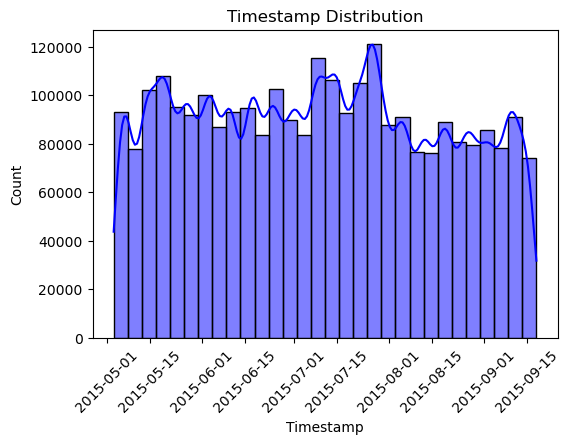

In [65]:
# Numeric Columns
plt.figure(figsize=(6,4))
sns.histplot(events_df['timestamp'], bins=30, kde=True, color='blue')
plt.title("Timestamp Distribution")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

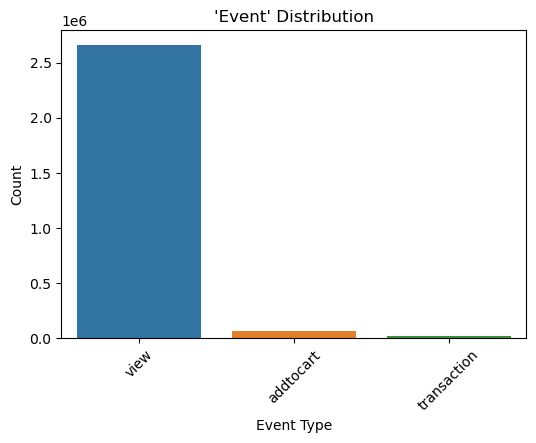

In [66]:
# Ensure correct column name
if 'event' in events_df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='event', data=events_df)  # Use correct column name
    plt.title("'Event' Distribution")
    plt.xlabel("Event Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate labels for better readability if needed
    plt.show()
else:
    print("Column 'event' not found in events_df!")


### Item Properties Dataset

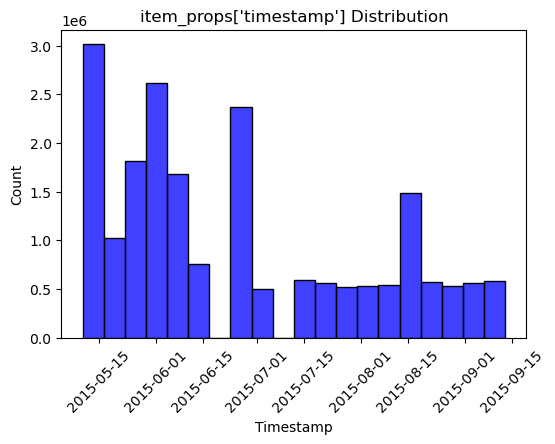

In [68]:
# Numeric Columns
plt.figure(figsize=(6,4))
sns.histplot(items_df['timestamp'], bins=20, kde=False, color='blue')
plt.title("item_props['timestamp'] Distribution")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

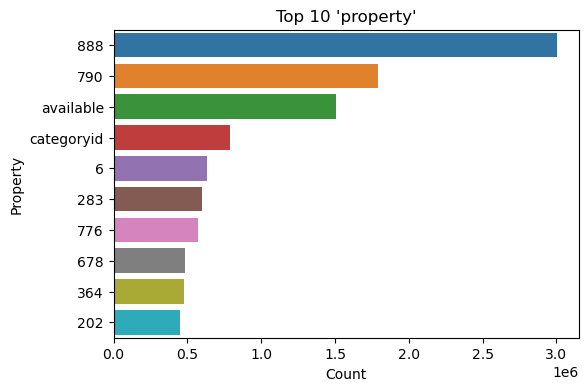

In [69]:
# Categorical Columns:
plt.figure(figsize=(6,4))
top_10_properties = items_df['property'].value_counts().head(10)
sns.barplot(x=top_10_properties.values, y=top_10_properties.index, orient='h')
plt.title("Top 10 'property'")
plt.xlabel("Count")
plt.ylabel("Property")
plt.show()

### Catergory Tree Datasets

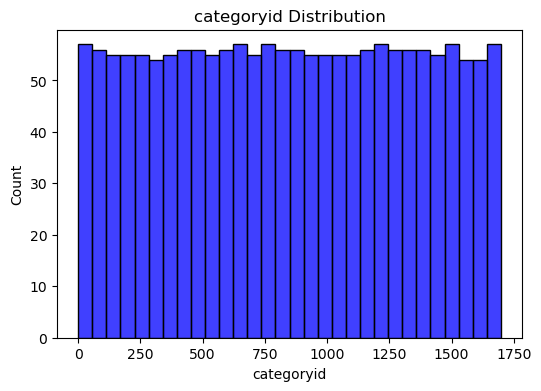

In [71]:
# Numeric Columns
plt.figure(figsize=(6,4))
sns.histplot(categories_df['categoryid'], bins=30, color='blue')
plt.title("categoryid Distribution")
plt.xlabel("categoryid")
plt.ylabel("Count")
plt.show()

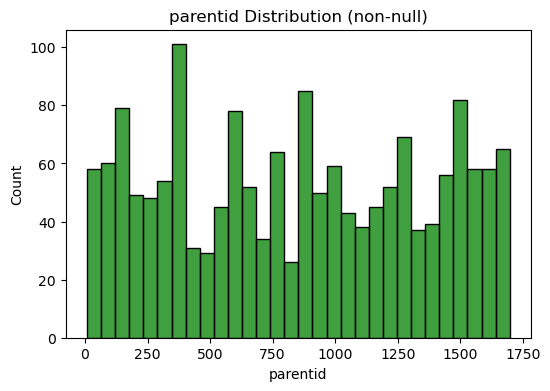

In [72]:
# Because parentid can be NaN or repeated, let's only plot non-null
df_parentid = categories_df[categories_df['parentid'].notna()].copy()
plt.figure(figsize=(6,4))
sns.histplot(df_parentid['parentid'], bins=30, color='green')
plt.title("parentid Distribution (non-null)")
plt.xlabel("parentid")
plt.ylabel("Count")
plt.show()

### 3. Bivariate Analysis

#### Events Dataset

In [99]:
# Ensure 'events_df' is properly loaded and 'transactionid' is treated correctly
if "events_df" not in globals():
    print("❌ Error: events_df is not defined. Ensure you have loaded the events dataset.")

# Filter for rows with a valid transaction ID
df_has_transactionid = events_df[events_df["transactionid"].notna()].copy()

if not df_has_transactionid.empty:
    # Count unique transaction IDs per event type
    transid_counts = df_has_transactionid.groupby("event")["transactionid"].nunique()

    print("🔹 Unique transaction ID count per event:")
    print(transid_counts)
else:
    print("⚠️ No rows with non-null transactionid in 'events_df' for bivariate analysis.")

🔹 Unique transaction ID count per event:
event
transaction    17672
Name: transactionid, dtype: int64


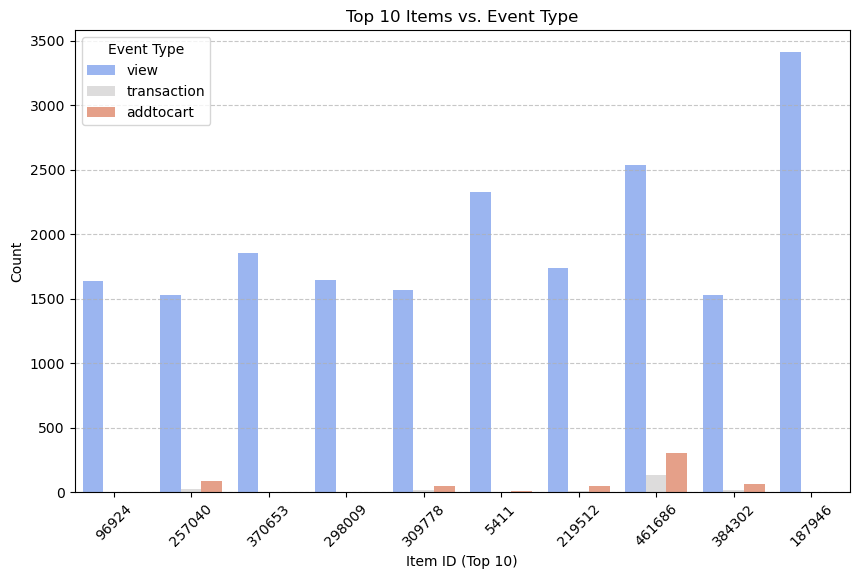

In [101]:
# Get the top 10 most frequent item IDs
top_items = events_df["itemid"].value_counts().head(10).index

# Filter dataset for only the top items
df_top_items = events_df[events_df["itemid"].isin(top_items)].copy()

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(x="itemid", hue="event", data=df_top_items, palette="coolwarm")

# Formatting
plt.title("Top 10 Items vs. Event Type")
plt.xlabel("Item ID (Top 10)")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.legend(title="Event Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [110]:
import pandas as pd

# Ensure 'items_df' is loaded
if "items_df" not in globals():
    print("❌ Error: items_df is not defined. Ensure you have loaded the item properties dataset.")

# Convert timestamp column to datetime format
items_df["timestamp"] = pd.to_datetime(items_df["timestamp"], errors="coerce")

# Ensure there are no missing values in relevant columns
items_df.dropna(subset=["timestamp", "property"], inplace=True)

# Group by timestamp and property, then count occurrences
prop_vs_ts = items_df.groupby(["timestamp", "property"]).size().reset_index(name="count")

# Show top 10 combinations by count
top_10_prop_ts = prop_vs_ts.nlargest(10, "count")

# Print results
print("Top 10 (timestamp, property) combos by frequency")
print(top_10_prop_ts)



Top 10 (timestamp, property) combos by frequency
              timestamp    property   count
402 2015-05-10 03:00:00         888  277369
362 2015-05-10 03:00:00         790  240223
457 2015-05-10 03:00:00   available  232060
458 2015-05-10 03:00:00  categoryid  214522
130 2015-05-10 03:00:00         283  208185
171 2015-05-10 03:00:00         364  205376
306 2015-05-10 03:00:00         678  205070
48  2015-05-10 03:00:00         112  203355
346 2015-05-10 03:00:00         764  203261
280 2015-05-10 03:00:00           6  203256


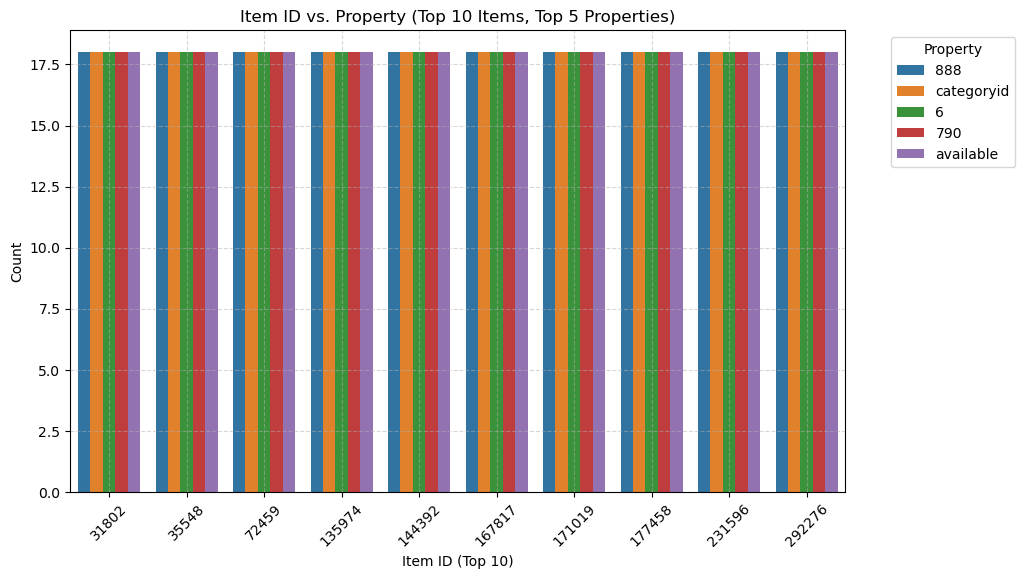

In [112]:
# Ensure 'items_df' is loaded
if "items_df" not in globals():
    print("❌ Error: items_df is not defined. Ensure you have loaded the item properties dataset.")

# Select the top 5 most common properties
top_5_properties = items_df["property"].value_counts().head(5).index

# Filter dataset for only these properties
df_bi_prop = items_df[items_df["property"].isin(top_5_properties)]

# Select the top 10 most common items
top_10_items = df_bi_prop["itemid"].value_counts().head(10).index

# Filter dataset again for only these items
df_bi_prop = df_bi_prop[df_bi_prop["itemid"].isin(top_10_items)]

# ✅ Plot property vs. item ID
plt.figure(figsize=(10, 6))
sns.countplot(x="itemid", hue="property", data=df_bi_prop)
plt.title("Item ID vs. Property (Top 10 Items, Top 5 Properties)")
plt.xlabel("Item ID (Top 10)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Property", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### Category Tree Dataset

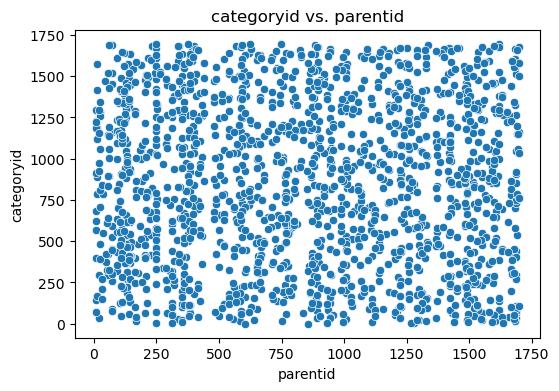

In [115]:
# categoryid vs. parentid
# We'll make a scatter plot as many parentids may be repeated, it's not super informative, but can show some pattern.

plt.figure(figsize=(6,4))
sns.scatterplot(x='parentid', y='categoryid', data=df_parentid)
plt.title("categoryid vs. parentid")
plt.xlabel("parentid")
plt.ylabel("categoryid")
plt.show()

### Multivariate Analysis

#### Events Dataset

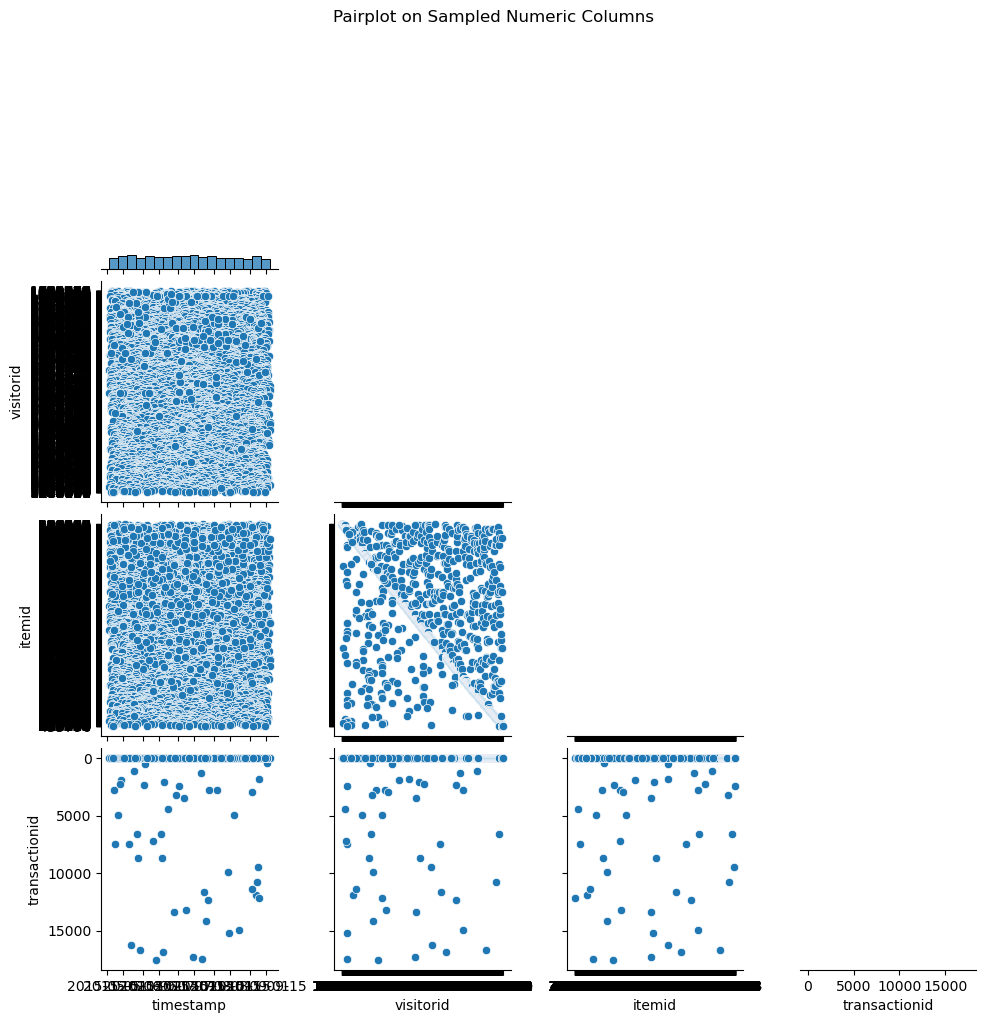

In [123]:
# Because most columns are IDs or strings, pairplots/correlation matrices
# are less meaningful. We'll demonstrate a pairplot on numeric columns
# (timestamp, visitorid, itemid, transactionid) using a small sample.

sample_size = 5000
df_sample = events_df.sample(sample_size, random_state=42).copy()

# Convert any NaNs in transactionid to 0 or -1 for pairplot
df_sample['transactionid'] = df_sample['transactionid'].fillna(-1)

sns.pairplot(df_sample, vars=['timestamp','visitorid','itemid','transactionid'], corner=True)
plt.suptitle("Pairplot on Sampled Numeric Columns", y=1.02)
plt.show()

#### Item Properties Dataset

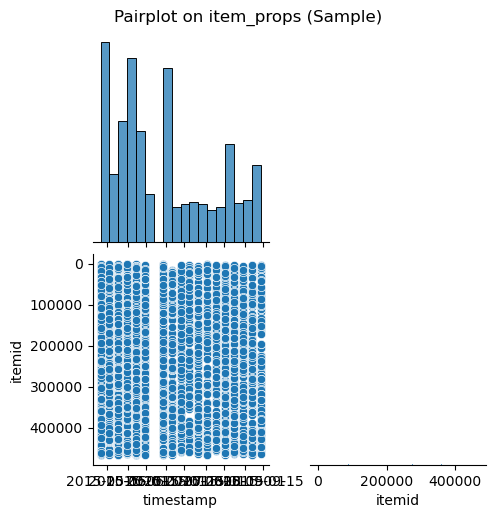

In [130]:
sample_size = 5000
df_ip_sample = items_df.sample(sample_size, random_state=42).copy()

sns.pairplot(df_ip_sample, vars=['timestamp','itemid'], corner=True)
plt.suptitle("Pairplot on item_props (Sample)", y=1.02)
plt.show()

### 4. Research/ Analytical Questions

#### A) What are the top items customers add to cart?

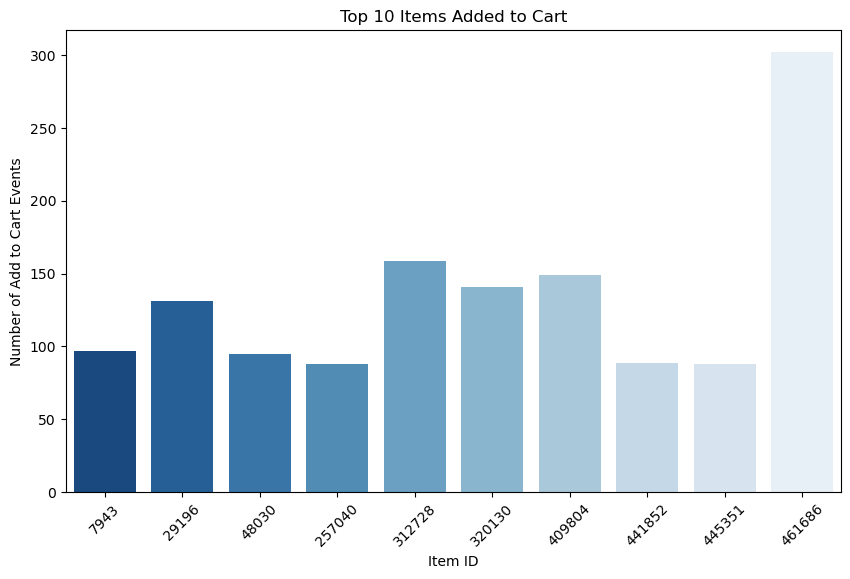

In [75]:
# Top items added to cart by customers
top_addtocart_items = events_df[events_df['event'] == 'addtocart']['itemid'].value_counts().head(10)

# Sort values in ascending order for better visualization
top_addtocart_items = top_addtocart_items.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_addtocart_items.index, y=top_addtocart_items.values, palette="Blues_r")
plt.title('Top 10 Items Added to Cart')
plt.xlabel('Item ID')
plt.ylabel('Number of Add to Cart Events')
plt.xticks(rotation=45)
plt.show()


#### B) What are the top 10 items viewed by Customers?

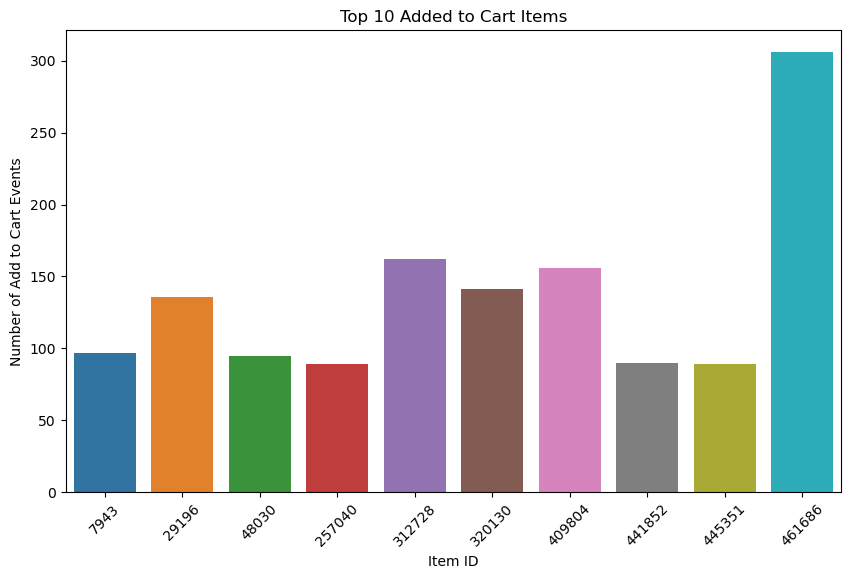

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Import the missing module

# Define the base directory (update this path to your dataset location)
base_dir = r"C:\Users\sammu\Downloads\Recommendation System Project"

# Load the data
events_df = pd.read_csv(os.path.join(base_dir, "events.csv"))

# Top items Added to Cart by customers
top_addtocart_items = events_df[events_df['event'] == 'addtocart']['itemid'].value_counts().head(10)

# Sort values in ascending order for better visualization
top_addtocart_sorted = top_addtocart_items.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_addtocart_sorted.index, y=top_addtocart_sorted.values)
plt.title('Top 10 Added to Cart Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Add to Cart Events')
plt.xticks(rotation=45)
plt.show()

#### What are the total transactions over time?

✅ Successfully loaded events_df

🔹 Data Types in events_df:
timestamp         int64
visitorid         int64
event            object
itemid            int64
transactionid    object
dtype: object
✅ Successfully converted timestamp to datetime.


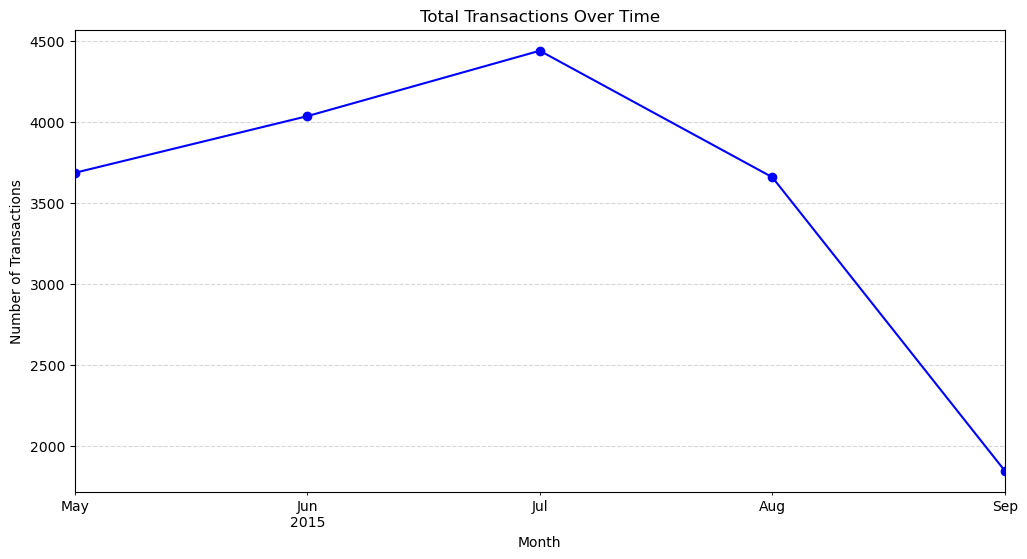

In [79]:


# Define base directory (Update path if needed)
base_dir = r"C:\Users\sammu\Downloads\Recommendation System Project"

# Load events dataset with low memory usage
events_file_path = os.path.join(base_dir, "events.csv")

if os.path.exists(events_file_path):
    events_df = pd.read_csv(events_file_path, dtype={"transactionid": str}, low_memory=False)
    print("✅ Successfully loaded events_df")
else:
    print(f"❌ Error: File not found at {events_file_path}")
    exit()

# 🔍 **Check Data Types**
print("\n🔹 Data Types in events_df:")
print(events_df.dtypes)

# **Ensure 'timestamp' exists**
if "timestamp" not in events_df.columns:
    print("❌ Error: 'timestamp' column not found in events_df.")
    exit()

# 🔍 **Convert 'timestamp' to datetime format**
try:
    events_df["timestamp"] = pd.to_datetime(events_df["timestamp"], unit="ms", errors="coerce")
    print("✅ Successfully converted timestamp to datetime.")
except Exception as e:
    print(f"❌ Error converting timestamp: {e}")
    exit()

# **Drop any NaN timestamps that couldn't be converted**
events_df = events_df.dropna(subset=["timestamp"])

# **Extract month-year for analysis**
events_df["month"] = events_df["timestamp"].dt.to_period("M")

# 🔍 **Count unique transactions per month**
transaction_trends = events_df[events_df["transactionid"].notnull()].groupby("month")["transactionid"].nunique()

# Ensure there are valid data points
if transaction_trends.empty:
    print("⚠️ Warning: No valid transaction data found.")
else:
    # 📊 **Plot transaction trends**
    plt.figure(figsize=(12, 6))
    transaction_trends.plot(marker="o", color="b", linestyle="-")

    plt.title("Total Transactions Over Time")
    plt.xlabel("Month")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


#### How many customers purcahsed or did not purchase an item?

In [91]:
# Customer who purchase items
print("***Customers who purchase Items***")
customer_purchase = events_df[events_df.transactionid.notnull()].visitorid.unique().size
print(customer_purchase)
print("\n")

# Customer who did not purchase items
print("*** Customers who did not purchase Items***")
customer_no_purchase = events_df[events_df.transactionid.isnull()].visitorid.unique().size
print(customer_no_purchase)

***Customers who purchase Items***
11719


*** Customers who did not purchase Items***
1407500


#### Top 10 most active users

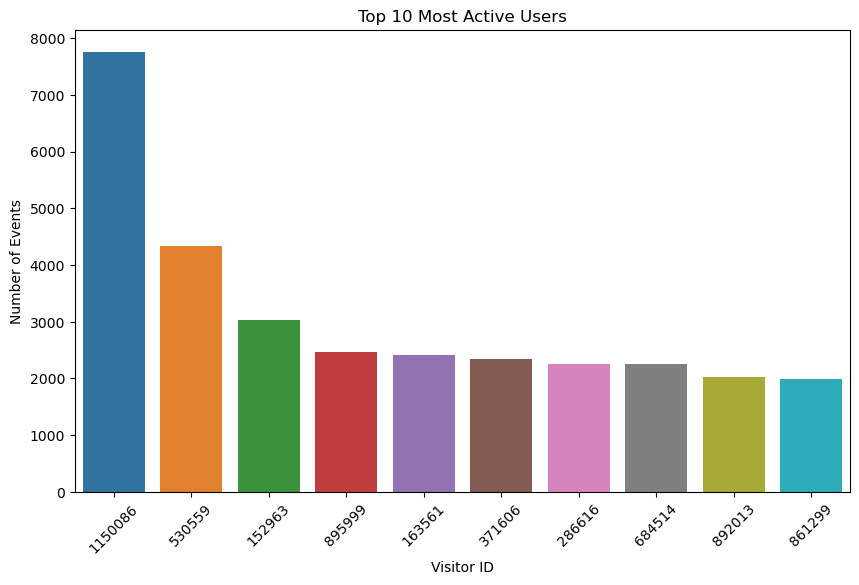

In [83]:
# Get the top 10 most active users
top_most_active_user = events_df['visitorid'].value_counts().head(10).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_most_active_user.index, y=top_most_active_user.values, order=top_most_active_user.index)

# Labels and title
plt.title('Top 10 Most Active Users')
plt.xlabel('Visitor ID')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [87]:
# Ensure 'visitorid' and 'itemid' are strings for accurate merging
events_df["visitorid"] = events_df["visitorid"].astype(str)
events_df["itemid"] = events_df["itemid"].astype(str)

# 🔹 Filter data based on event types
item_tra = events_df[events_df["event"] == "transaction"][["visitorid", "itemid", "timestamp"]]
item_atc = events_df[events_df["event"] == "addtocart"][["visitorid", "itemid", "timestamp"]]
item_view = events_df[events_df["event"] == "view"][["visitorid", "itemid", "timestamp"]]

# 🔹 Merge transactions and add-to-cart data
m = item_tra.merge(item_atc, on=["visitorid", "itemid"], how="inner", suffixes=("(transaction)", "(addtocart)"))

# 🔹 Merge the result with viewed items
m = m.merge(item_view, on=["visitorid", "itemid"], how="inner")

# 🔹 Rename the timestamp column for views
m = m.rename(columns={"timestamp": "timestamp(view)"})

# 🔹 Display first 10 rows
m.head(10)


,visitorid,itemid,timestamp(transaction),timestamp(addtocart),timestamp(view)
0,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-02 05:11:36.102
1,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-03 02:12:25.235
2,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-06 21:10:10.602
3,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-08 02:44:57.480
4,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 00:34:37.794
5,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 00:34:09.376
6,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 18:22:47.121
7,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 18:17:39.198
8,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 19:05:02.402
9,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 21:57:42.396


#### What items are frequently viewed but least purchased?

In [ ]:

# Count views per item
item_views = events_df[events_df['event'] == 'view'].groupby('itemid')['visitorid'].nunique()

# Count purchases per item
item_purchases = events_df[events_df['transactionid'].notnull()].groupby('itemid')['visitorid'].nunique()

# Fill missing values with 0 (some items might not have been purchased)
item_purchases = item_purchases.reindex(item_views.index, fill_value=0)

# Calculate view-to-purchase ratio
view_to_purchase_ratio = item_views / (item_purchases + 1) 

# Identify top 10 items with highest views but lowest purchases
low_conversion_items = view_to_purchase_ratio.sort_values(ascending=False).head(10)

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=low_conversion_items.index, y=low_conversion_items.values, palette='Blues_r')
plt.title('Top 10 Items with High Views but Low Purchases')
plt.xlabel('Item ID')
plt.ylabel('View-to-Purchase Ratio')
plt.xticks(rotation=45)
plt.show()

# Display data
low_conversion_items_df = pd.DataFrame({
    'Item ID': low_conversion_items.index,
    'Views': item_views[low_conversion_items.index],
    'Purchases': item_purchases[low_conversion_items.index],
    'View-to-Purchase Ratio': low_conversion_items.values
})

print(low_conversion_items_df)

### Pivoting Item Properties for Better Analysis
#### Goal: Convert property column into multiple columns (one for each attribute).

In [ ]:
# Check for duplicate item-property pairs
duplicate_entries = items_df.duplicated(subset=["itemid", "property"], keep=False)
print("Duplicate Entries Found:", items_df[duplicate_entries].head())

# Resolve duplicates by keeping the latest value
items_df = items_df.groupby(["itemid", "property"]).agg({"value": "last"}).reset_index()

# Pivot the cleaned dataset
items_pivot = items_df.pivot(index="itemid", columns="property", values="value").reset_index()

print("✅ Pivot successful! Shape of new dataframe:", items_pivot.shape)
display(items_pivot.head())


### Many columns have NaN values due to missing property values for certain items.
##### Filling missing values with appropriate defaults:

In [ ]:
items_pivot.fillna("Unknown", inplace=True)  # Use "Unknown" for categorical data
# OR
items_pivot.fillna(0, inplace=True)  # Use 0 for numerical data

In [ ]:
# Example: If you have a mapping dictionary
property_mapping = {0: "Color", 1: "Size", 10: "Material"}  # Update with actual mappings
items_pivot.rename(columns=property_mapping, inplace=True)


In [ ]:
print(items_pivot.info())  # Check column data types
print(items_pivot.head())  # Preview cleaned dataset